# Twitter Keyword Co-occurrence Networks Analysis

This notebook performs a detailed analysis on different keyword co-occurrence networks that can be created with automatic keywords extracted from tweets using different data preprocessing approaches.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
from matplotlib import pyplot as plt
from itertools import combinations
import math

The processed tweets are in XML format, with an ID element, a sentiment element, and multiple keyword elements. The sentiment element contains a negative, neutral, positive, and compound score. The keyword elements each contain a local relevance score and the keyword itself.

The data is in different files based on the length of keywords. File 'conf1_1_combine.xml' contains 1-1 keywords, file 'conf1_2_combine.xml' contains 1-2 keywords, etc.

In [2]:
tree1_1 = ET.parse('conf1_1_combine.xml')
root1_1 = tree1_1.getroot()

tree1_2 = ET.parse('conf1_2_combine.xml')
root1_2 = tree1_2.getroot()

tree1_3 = ET.parse('conf1_3_combine.xml')
root1_3 = tree1_3.getroot()

tree2_2 = ET.parse('conf2_2_combine.xml')
root2_2 = tree2_2.getroot()

tree2_3 = ET.parse('conf2_3_combine.xml')
root2_3 = tree2_3.getroot()

tree3_3 = ET.parse('conf3_3_combine.xml')
root3_3 = tree3_3.getroot()

This function is used to select a subset of tweets based on their compound score sentiment:

In [3]:
def find_tweets(root, lower_compound_threshold, upper_compound_threshold):
    selected_tweets = []
    ind = 0
    for tweet in root:
        compound_score = float(tweet[1].text[tweet[1].text.find('compound')+11:tweet[1].text.find('}')])
        if compound_score < upper_compound_threshold and compound_score > lower_compound_threshold:
            selected_tweets.append(ind)
        ind += 1
    
    return selected_tweets

This function creates the word co-occurrence network based on a given set of tweets and their keywords. Keywords can be removed if they only occur once and have a local relevance score below a certain threshold or if they occur in a list of user-defined noisy keywords.

In [4]:
def create_graph(root, score_threshold, noisy_keywords = None):
    # keywords are tracked based on how often they occur, how often they occur together, and their local relevance score(s)
    keyword_count = dict()
    keyword_pairs_counts = dict()
    keyword_scores = dict()
    
    # looping through the tweets
    for tweet in root:
        keywords = []
        
        # id and sentiment are elements 0 and 1, hence tweets start at element 2
        # each element has the relevance score and the keyword itself, separated by ','
        for keyword_score_pair in tweet[2:]:
            score = float(keyword_score_pair.text[1:keyword_score_pair.text.find(',')])
            keyword = keyword_score_pair.text[keyword_score_pair.text.find(',')+3:keyword_score_pair.text.find(')')-1]
            
            # counts of keywords are tracked
            if keyword not in keywords:
                keywords.append(keyword)
                if keyword in keyword_count:
                    keyword_count[keyword] += 1
                else:
                    keyword_count[keyword] = 1
            keyword_scores[keyword] = score
                        
        
        # if a keyword in a tweet is a subset of another keyword in the tweet, only the longer keyword is kept
        exclude_keywords = []
        for keyword_pair in list(combinations(keywords, 2)):
            if keyword_pair[0] in keyword_pair[1]:
                exclude_keywords.append(keyword_pair[0])
            elif keyword_pair[1] in keyword_pair[0]:
                exclude_keywords.append(keyword_pair[1])

        for keyword in exclude_keywords:
            if keyword in keywords:
                keywords.remove(keyword)
                keyword_count[keyword] -= 1
        
        # counts are tracked for how often keywords occur together
        for keyword_pair in list(combinations(keywords, 2)):
            if frozenset(keyword_pair) in keyword_pairs_counts:
                keyword_pairs_counts[frozenset(keyword_pair)] += 1
            else:
                keyword_pairs_counts[frozenset(keyword_pair)] = 1
    
    
    # a graph is created with keywords as nodes with a 'count' attribute 
    # edges are weighted based on how regularly the keywords occur together
    G = nx.Graph()
    G.add_nodes_from(list(keyword_count.keys()))
    nx.set_node_attributes(G, keyword_count, name="count")

    for edge_to_add in keyword_pairs_counts:
        nodes = list(edge_to_add)
        G.add_edge(nodes[0], nodes[1], weight = keyword_pairs_counts[edge_to_add])
        
    # keywords that only occur once and score below a given score threshold are removed
    remove_count = [node for node,count in nx.get_node_attributes(G, 'count').items() if count == 1]
    remove_score = [node for node,score in keyword_scores.items() if score < score_threshold]
    remove = list(set(remove_count) & set(remove_score))
    G.remove_nodes_from(remove)
    
    # all keywords defined as noisy are removed
    if noisy_keywords:
        G.remove_nodes_from(noisy_keywords)
        
    return(G)

Positive, negative, and neutral tweets are defined based on their compound score.

In [5]:
positive_tweets = find_tweets(root1_1, 0.05, 1)
negative_tweets = find_tweets(root1_1, -1, -0.05)
neutral_tweets = find_tweets(root1_1, -0.05, 0.05)

A single set of noisy keywords is defined, and three score thresholds are tested (these are based on the most common scores).

In [6]:
noisy_keywords = ['rt', 'amp', '…', 'co', 'https ://', '’', '.…']
score_thresholds = [1, 2, 5]

In [7]:
all_graphs = {}
for score_threshold in score_thresholds:
    all_graphs['graph_pos_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_11_' + str(score_threshold)] = create_graph(root1_1, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_12_' + str(score_threshold)] = create_graph(root1_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_13_' + str(score_threshold)] = create_graph(root1_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_22_' + str(score_threshold)] = create_graph(root2_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_23_' + str(score_threshold)] = create_graph(root2_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_33_' + str(score_threshold)] = create_graph(root3_3, score_threshold, noisy_keywords)

## Global Network Properties

We can create a properties table to see an overview of all graph statistics.

In [8]:
def generate_network_prop_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'nodes', 'edges', 'edge_weight', 'components'])
    for setup in graphs:
        graph = graphs[setup]
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        edge_weight = graph.size(weight='weight')
        component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'nodes': [num_nodes], 'edges': [num_edges]
                                            ,'edge_weight': [edge_weight], 'components': [component_sizes]})], ignore_index = True)
        
    return network_prop_df

We first generate properties of all graphs with no score threshold.

In [9]:
no_score_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if key[-1] == '1']}

In [10]:
generate_network_prop_table(no_score_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_1,4947,21795,24417.0,"[4420, 9, 8, 8, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, ..."
1,graph_neg_11_1,4002,16139,19723.0,"[3341, 10, 10, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6..."
2,graph_neu_11_1,6847,17586,20212.0,"[4548, 34, 27, 15, 14, 13, 13, 12, 10, 10, 10,..."
3,graph_all_11_1,12326,54052,64352.0,"[10129, 17, 15, 13, 13, 12, 10, 10, 9, 9, 9, 8..."
4,graph_pos_12_1,8669,43724,48214.0,"[7868, 12, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 7..."
5,graph_neg_12_1,6975,33225,39097.0,"[6063, 13, 11, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7..."
6,graph_neu_12_1,10935,35550,39808.0,"[7894, 20, 19, 18, 14, 14, 14, 14, 13, 12, 12,..."
7,graph_all_12_1,22606,110807,127119.0,"[19489, 25, 18, 14, 14, 12, 12, 11, 11, 11, 11..."
8,graph_pos_13_1,10258,53186,58374.0,"[9269, 14, 14, 12, 10, 10, 10, 9, 9, 8, 8, 8, ..."
9,graph_neg_13_1,8315,41022,47523.0,"[7192, 15, 12, 11, 10, 10, 9, 9, 9, 9, 9, 9, 9..."


We also consider graphs with a score threshold.

In [11]:
thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2')]}

In [12]:
generate_network_prop_table(thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_2,1677,10146,12768.0,"[1595, 4, 4, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, ..."
1,graph_neg_11_2,1331,7527,11111.0,"[1262, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, ..."
2,graph_neu_11_2,1857,5376,8002.0,"[1520, 12, 10, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4..."
3,graph_all_11_2,4361,30072,40372.0,"[4045, 8, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, ..."
4,graph_pos_12_2,5415,26035,30525.0,"[4997, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, ..."
5,graph_neg_12_2,4314,19975,25847.0,"[3887, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
6,graph_neu_12_2,5964,16464,20722.0,"[4547, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 7, 7,..."
7,graph_all_12_2,14673,74304,90616.0,"[13139, 11, 11, 9, 8, 8, 7, 7, 7, 7, 7, 7, 6, ..."
8,graph_pos_13_2,7015,33427,38615.0,"[6410, 9, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ..."
9,graph_neg_13_2,5659,25876,32377.0,"[5021, 11, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."


In [13]:
thresh_all_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2') and 'all' in key]}

In [14]:
generate_network_prop_table(thresh_all_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_all_11_2,4361,30072,40372.0,"[4045, 8, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, ..."
1,graph_all_12_2,14673,74304,90616.0,"[13139, 11, 11, 9, 8, 8, 7, 7, 7, 7, 7, 7, 6, ..."
2,graph_all_13_2,19936,96489,115167.0,"[17457, 22, 17, 11, 11, 11, 10, 9, 9, 9, 9, 9,..."
3,graph_all_22_2,10296,10339,11221.0,"[2076, 28, 22, 20, 20, 17, 17, 17, 16, 16, 16,..."
4,graph_all_23_2,15524,20234,21966.0,"[3280, 34, 27, 26, 26, 24, 23, 21, 21, 20, 18,..."
5,graph_all_33_2,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
6,graph_all_11_5,4361,30072,40372.0,"[4045, 8, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, ..."
7,graph_all_12_5,5661,41329,57641.0,"[5313, 9, 7, 7, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, ..."
8,graph_all_13_5,10924,57660,76338.0,"[9643, 15, 14, 9, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5..."
9,graph_all_22_5,1272,1231,2113.0,"[495, 10, 8, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, ..."


Graphs created with 2-2, 2-3, and 3-3 keywords have low connectivity, so we focus on 1-1, 1-2, and 1-3 graphs.

In [15]:
pos_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1']}
neg_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1']}
neu_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_1', 'graph_neu_12_1', 'graph_neu_13_1']}
all_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1']}

pos_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2']}
neg_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2']}
neu_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_2', 'graph_neu_12_2', 'graph_neu_13_2']}
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}

pos_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5']}
neg_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}
neu_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_5', 'graph_neu_12_5', 'graph_neu_13_5']}
all_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

#### Centrality Distributions

In [16]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

We plot the degree centrality and node strength distributions for positive, negative, neutral, and all graphs with different score relevance thresholds applied.

Text(0.5, 0.98, 'Degree centrality distribution (no threshold)')

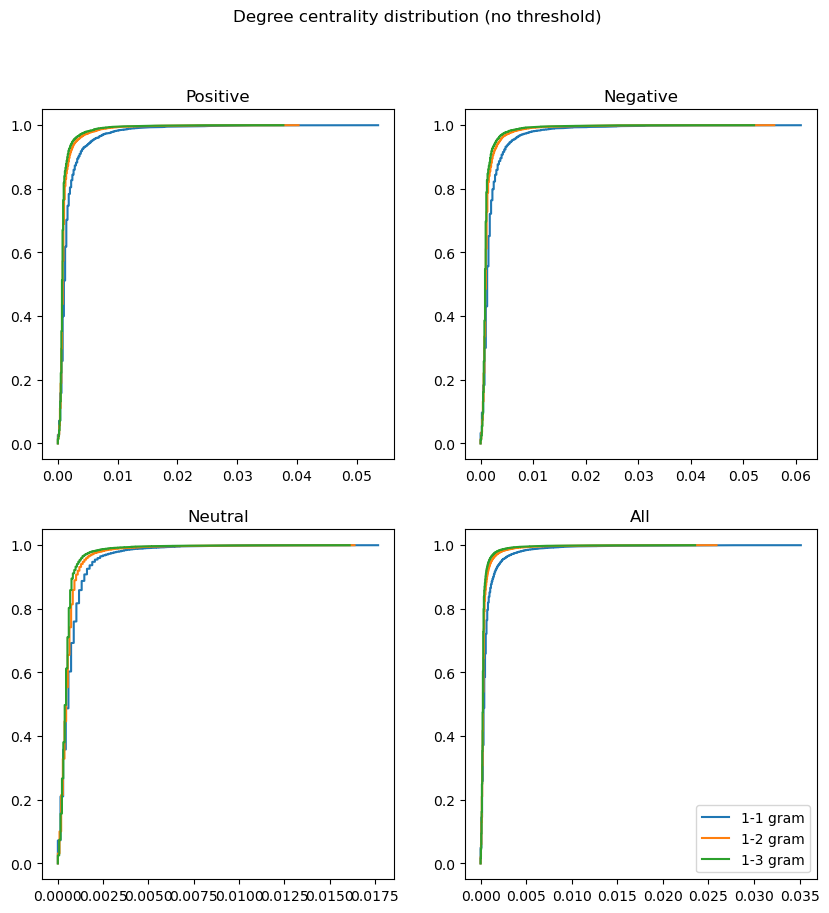

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_no_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_no_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_no_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_no_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (no threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (low threshold)')

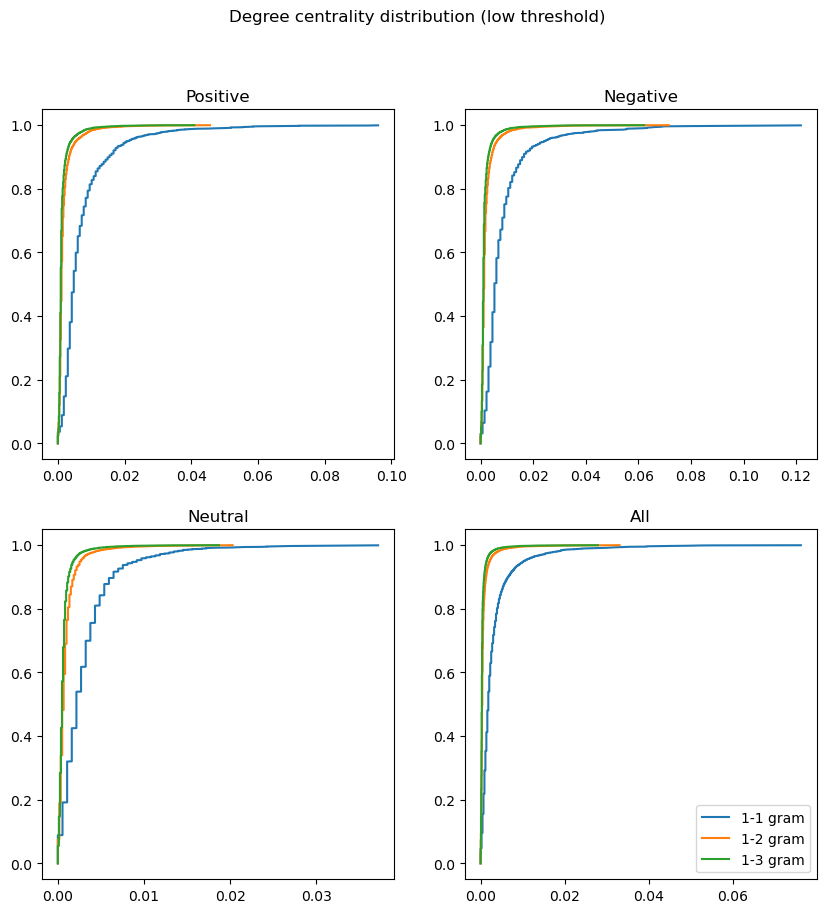

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_low_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_low_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_low_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (low threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (high threshold)')

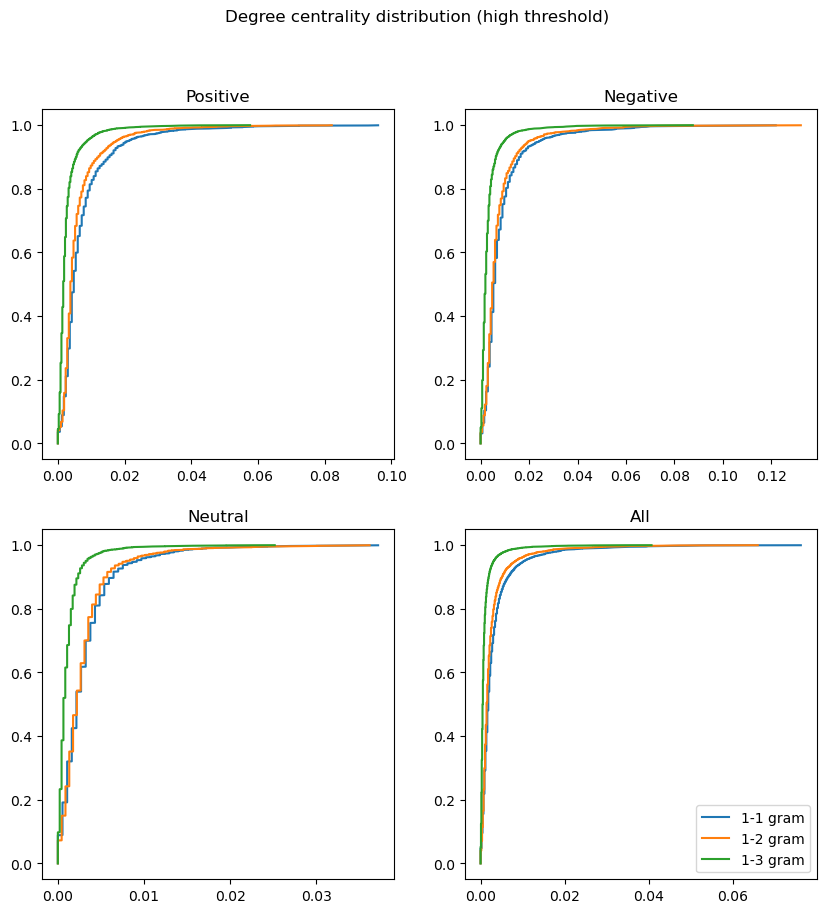

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_high_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_high_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_high_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_high_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (high threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (all tweets)')

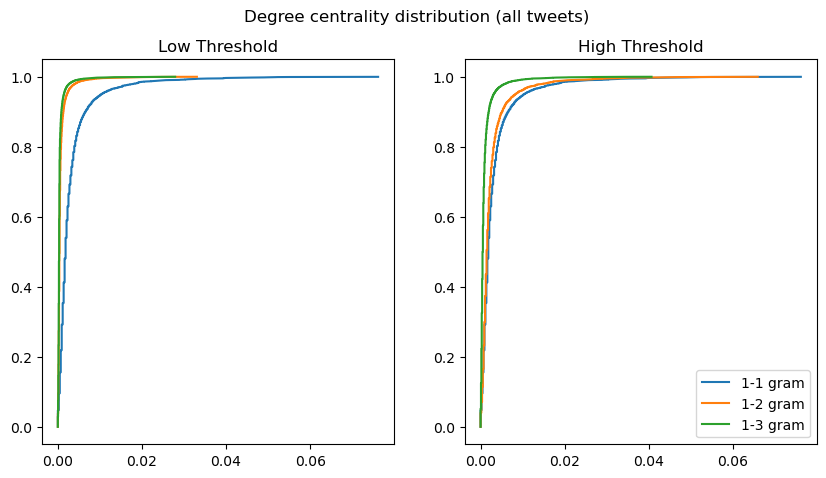

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
plot_graph_fun(all_high_thresh_graphs, 'degree_centrality', axes[1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')

axes[1].legend()
fig.suptitle('Degree centrality distribution (all tweets)')

In [21]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

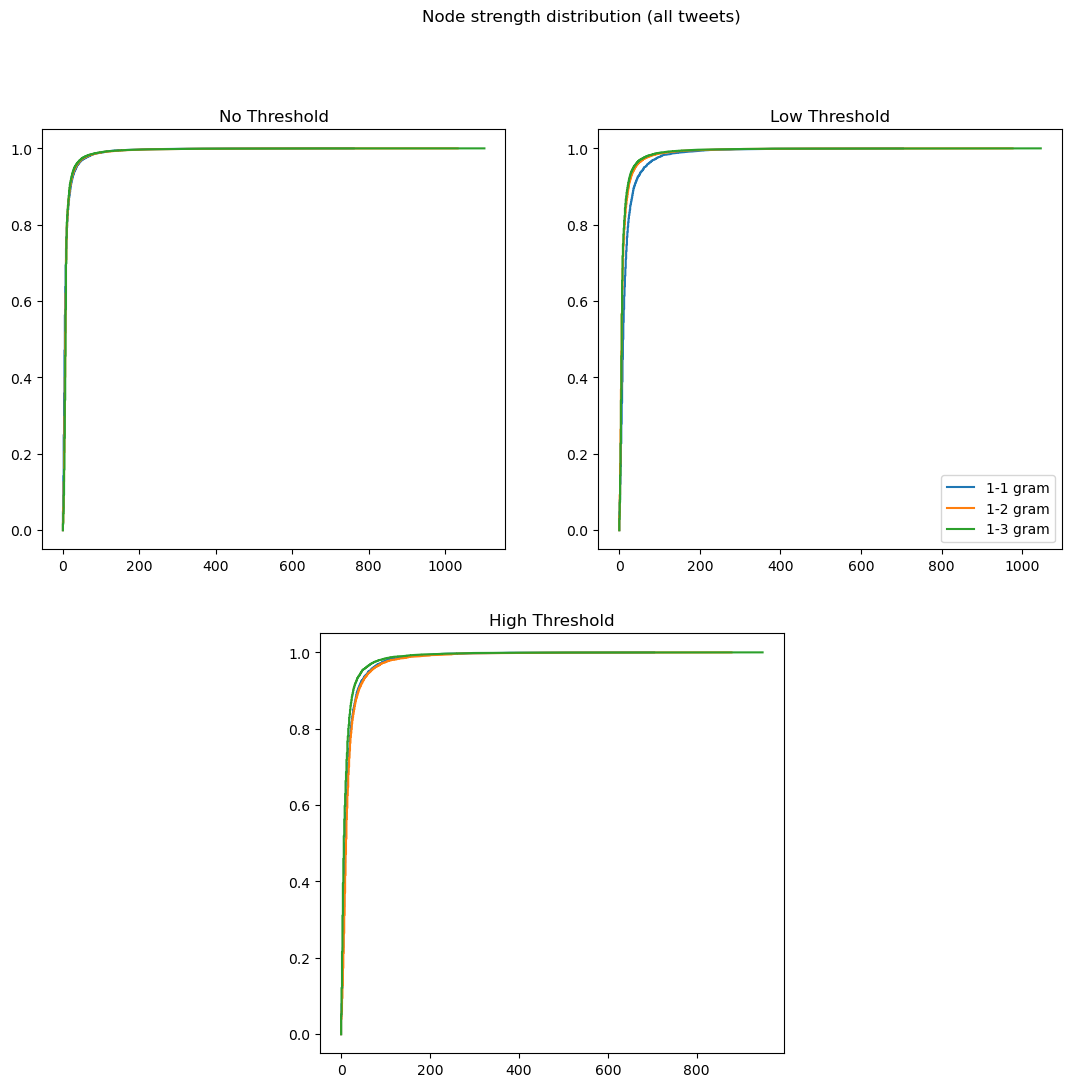

In [22]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(all_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(all_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(all_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')

ax2.legend()
fig.suptitle('Node strength distribution (all tweets)')
plt.show()

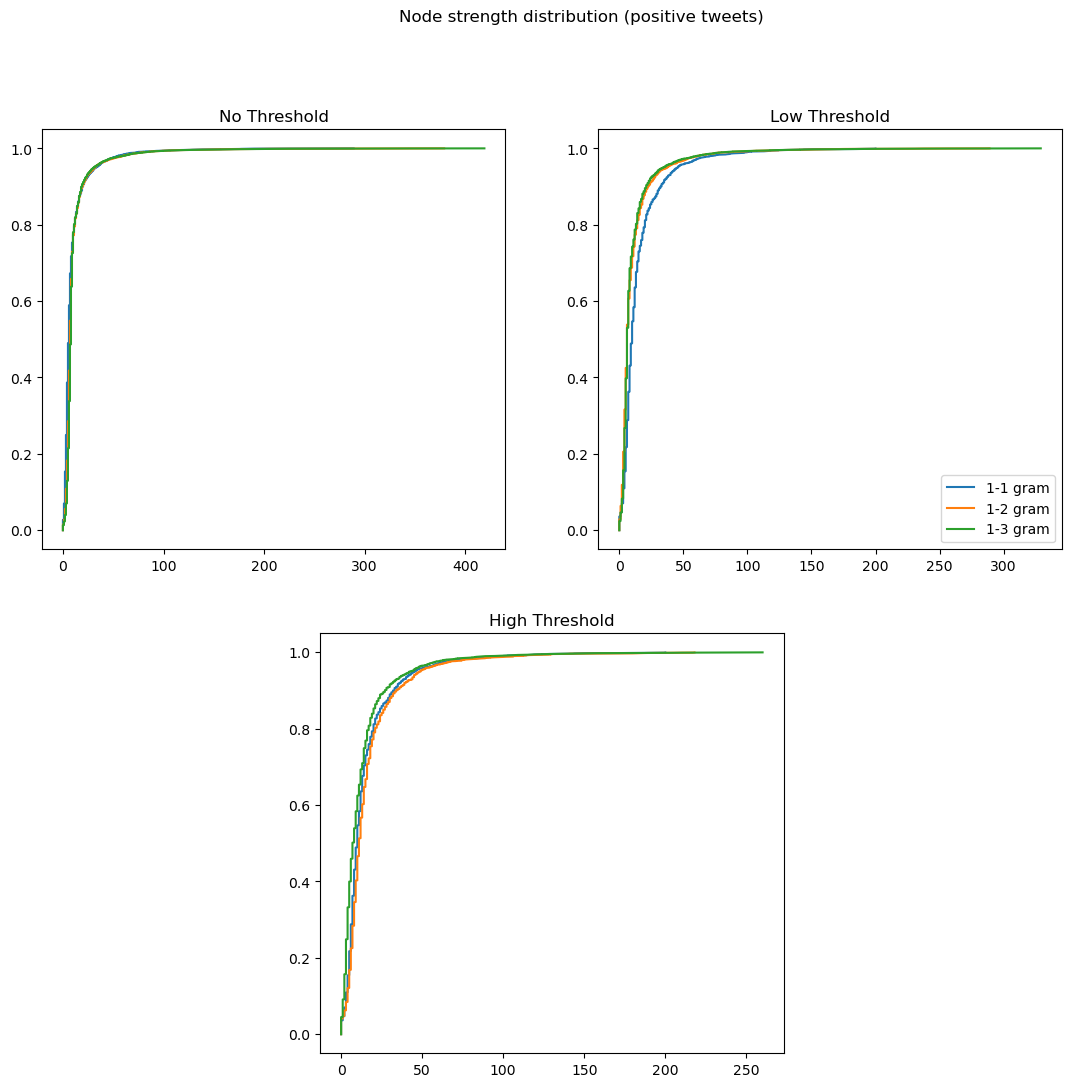

In [23]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(pos_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(pos_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(pos_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (positive tweets)')
plt.show()

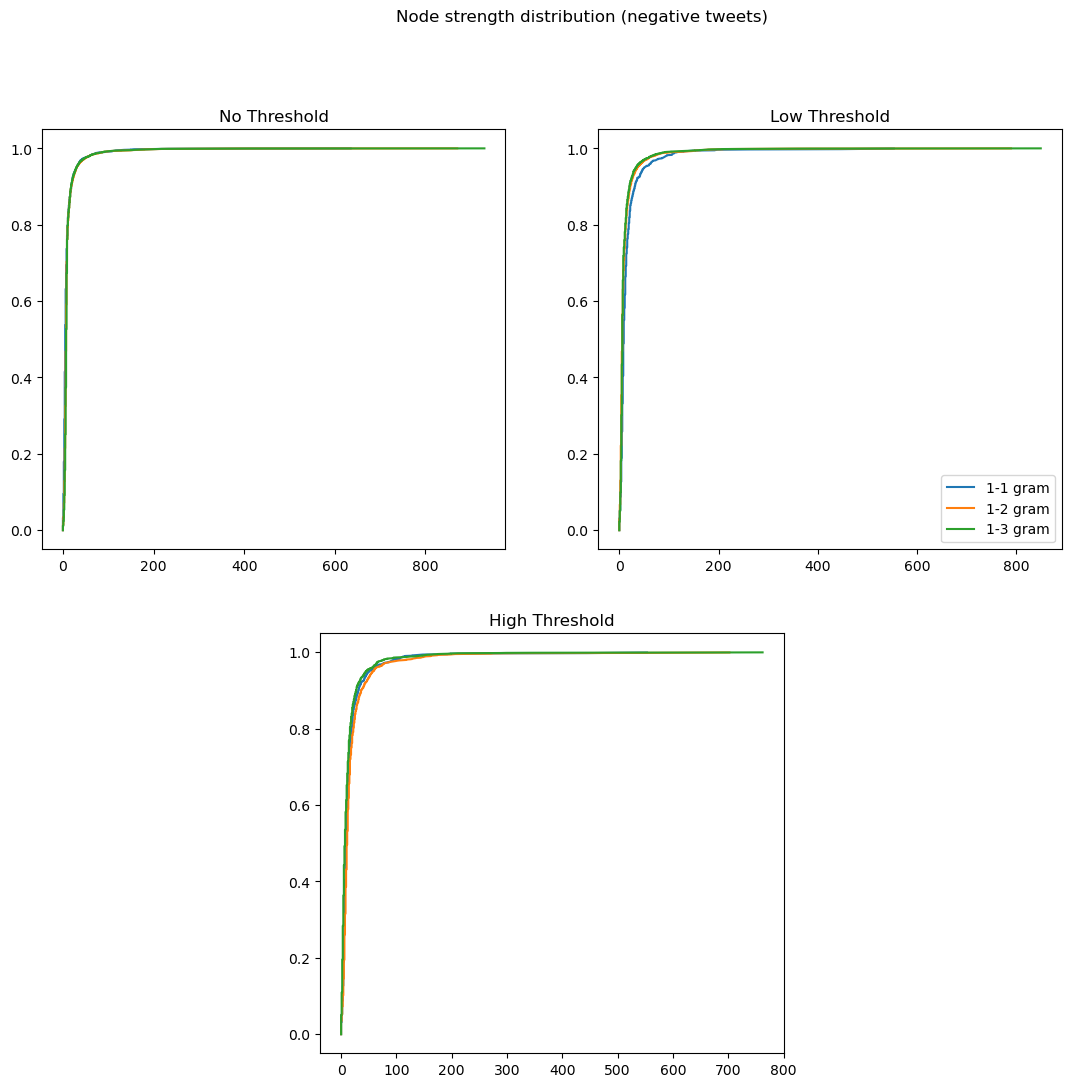

In [24]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(neg_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(neg_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(neg_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (negative tweets)')
plt.show()

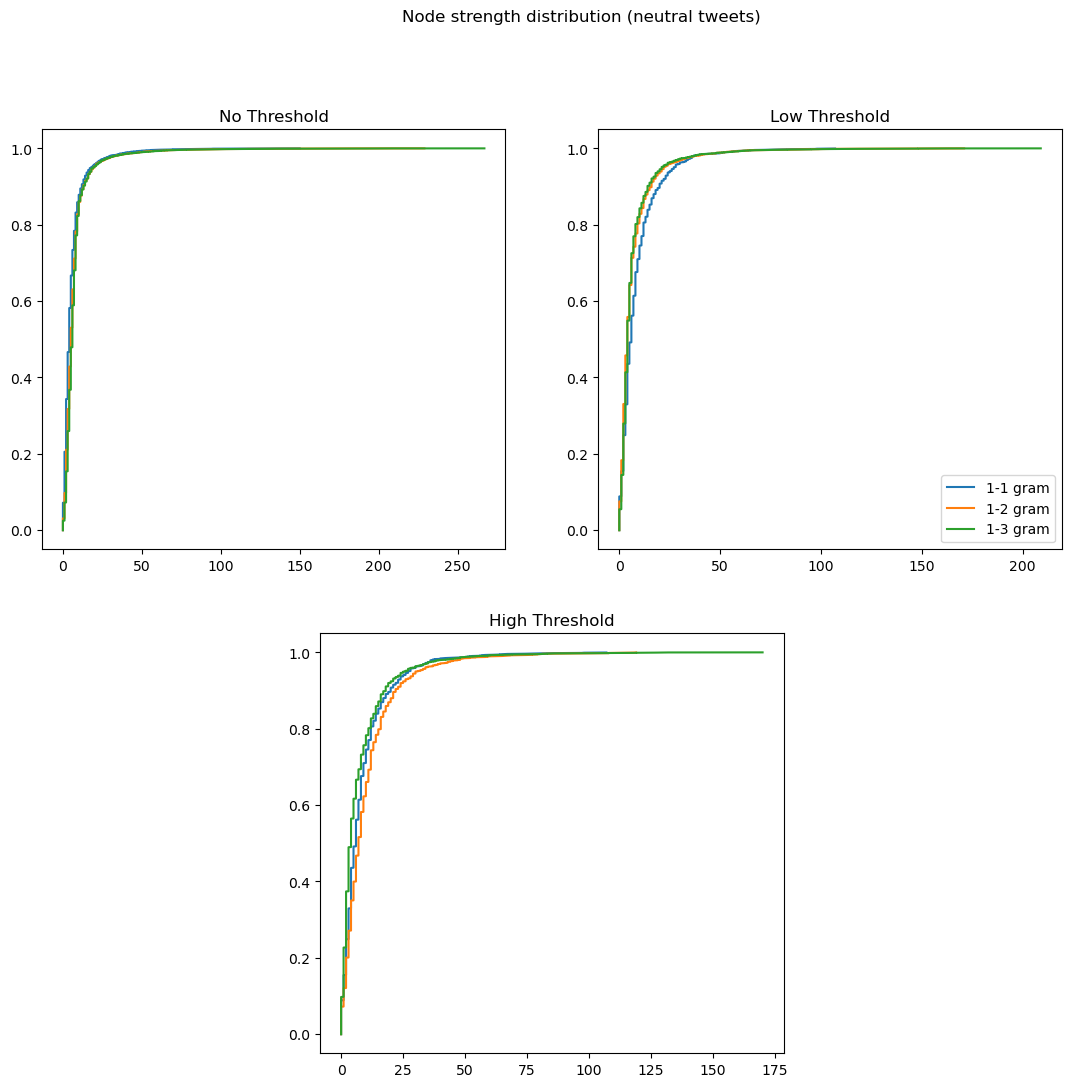

In [25]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(neu_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(neu_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(neu_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (neutral tweets)')
plt.show()

#### Node Assortivity

We can also calculate network assortivity values, to see how nodes tend to connect to each other based on their strength, degree, or count.

In [26]:
def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength', 'degree', 'count'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        degree_coeff = nx.degree_assortativity_coefficient(graph)
        count_coeff = nx.attribute_assortativity_coefficient(graph, 'count')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength], 'degree': [degree_coeff]
                                            ,'count': [count_coeff]})], ignore_index = True)
        
    return network_prop_df

For all 1-1, 1-2, 1-3 graphs, the assortivity values are low, and do not offer much insight.

In [27]:
generate_network_assort_table(thresh_graphs)

,setup,strength,degree,count
0,graph_pos_11_2,-0.041543,-0.036792,0.004185
1,graph_neg_11_2,-0.034922,-0.044144,0.006717
2,graph_neu_11_2,0.063741,0.088706,0.029041
3,graph_all_11_2,-0.021831,-0.015710,0.008754
4,graph_pos_12_2,-0.020888,-0.020217,0.025665
5,graph_neg_12_2,-0.028684,-0.035090,0.029545
6,graph_neu_12_2,0.029605,0.021908,0.056422
7,graph_all_12_2,-0.019783,-0.019430,0.021087
8,graph_pos_13_2,-0.014157,-0.014147,0.038512
9,graph_neg_13_2,-0.023630,-0.028787,0.041750


## Node ranking

For each graph, we can rank nodes based on their degree or node centralities.

In [28]:
# the function ranks nodes in multiple graphs at once
# since graphs can have different numbers of nodes, we can limit how many of the top nodes are retained
def sorted_cent(graphs, topN):
    degCent_df = pd.DataFrame()
    nodeStr_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]

        degCent = nx.degree_centrality(graph)
        degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
        
        degCent_df[setup] = list(degCent_sorted.keys())[0:topN]
        
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]
        
    return degCent_df, nodeStr_df

In [29]:
all_shortkey_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if '11' in key or '12' in key or '13' in key]}

In [30]:
degCent_rank_df, nodeStr_rank_df = sorted_cent(all_shortkey_graphs, 1000)

Rank-based overlap (RBO) shows how similar two ranked lists are. The p value dictates how much weight is given to comparisons of higher ranked nodes. The weightage calculator calculates what percentage of the score comes from the first d elements in the lists.

In [31]:
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

For a p value of 0.9, the top 13 nodes count for ~90% of the score; for a 0.99 p value, the top 130 count for ~90% of the score.

In [32]:
print(weightage_calculator(0.9, 13))
print(weightage_calculator(0.99, 130))

0.9079099164989892
0.9039562429806366


We calculate rank based overlap of networks created with all, positive, negative, and neutral tweets. We calculate these values for p values of 0.9 and 0.99. 

#### Node Strength Rankings

The shortlist ranking uses a p-value of 0.9 (meaning a smaller proportion of the rankings count towards the similarity score), while the longlist ranking uses a p-value of 0.99 (meaning a greateer proportion of the rankings count towards the score).

###### All Tweets

In [33]:
all_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'all' in x]]

In [34]:
nodeStr_shortlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_shortlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_all_df = nodeStr_shortlist_all_df.astype(float)

nodeStr_longlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_longlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_all_df = nodeStr_longlist_all_df.astype(float)

In [35]:
nodeStr_shortlist_all_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.942,0.933,0.960,0.932,0.935,0.960,0.916,0.912
graph_all_12_1,0.942,1.000,0.979,0.934,0.965,0.977,0.934,0.933,0.952
graph_all_13_1,0.933,0.979,1.000,0.928,0.951,0.964,0.928,0.923,0.944
graph_all_11_2,0.960,0.934,0.928,1.000,0.954,0.944,1.000,0.946,0.941
graph_all_12_2,0.932,0.965,0.951,0.954,1.000,0.977,0.954,0.966,0.977
graph_all_13_2,0.935,0.977,0.964,0.944,0.977,1.000,0.944,0.950,0.969
graph_all_11_5,0.960,0.934,0.928,1.000,0.954,0.944,1.000,0.946,0.941
graph_all_12_5,0.916,0.933,0.923,0.946,0.966,0.950,0.946,1.000,0.975
graph_all_13_5,0.912,0.952,0.944,0.941,0.977,0.969,0.941,0.975,1.000


In [36]:
nodeStr_longlist_all_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.875,0.868,0.938,0.868,0.864,0.938,0.837,0.838
graph_all_12_1,0.875,1.000,0.971,0.861,0.949,0.958,0.861,0.893,0.914
graph_all_13_1,0.868,0.971,1.000,0.856,0.935,0.955,0.856,0.883,0.910
graph_all_11_2,0.938,0.861,0.856,1.000,0.882,0.871,1.000,0.866,0.865
graph_all_12_2,0.868,0.949,0.935,0.882,1.000,0.965,0.882,0.935,0.946
graph_all_13_2,0.864,0.958,0.955,0.871,0.965,1.000,0.871,0.916,0.944
graph_all_11_5,0.938,0.861,0.856,1.000,0.882,0.871,1.000,0.866,0.865
graph_all_12_5,0.837,0.893,0.883,0.866,0.935,0.916,0.866,1.000,0.957
graph_all_13_5,0.838,0.914,0.910,0.865,0.946,0.944,0.865,0.957,1.000


###### Positive Tweets

In [37]:
pos_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'pos' in x]]

In [38]:
nodeStr_shortlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_shortlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_pos_df = nodeStr_shortlist_pos_df.astype(float)

nodeStr_longlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_longlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_pos_df = nodeStr_longlist_pos_df.astype(float)

In [39]:
nodeStr_shortlist_pos_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.955,0.950,0.880,0.890,0.913,0.880,0.854,0.877
graph_pos_12_1,0.955,1.000,0.981,0.846,0.883,0.917,0.846,0.848,0.885
graph_pos_13_1,0.950,0.981,1.000,0.844,0.880,0.921,0.844,0.847,0.891
graph_pos_11_2,0.880,0.846,0.844,1.000,0.943,0.862,1.000,0.920,0.844
graph_pos_12_2,0.890,0.883,0.880,0.943,1.000,0.899,0.943,0.940,0.864
graph_pos_13_2,0.913,0.917,0.921,0.862,0.899,1.000,0.862,0.863,0.941
graph_pos_11_5,0.880,0.846,0.844,1.000,0.943,0.862,1.000,0.920,0.844
graph_pos_12_5,0.854,0.848,0.847,0.920,0.940,0.863,0.920,1.000,0.900
graph_pos_13_5,0.877,0.885,0.891,0.844,0.864,0.941,0.844,0.900,1.000


In [40]:
nodeStr_longlist_pos_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.901,0.889,0.900,0.875,0.867,0.900,0.825,0.825
graph_pos_12_1,0.901,1.000,0.964,0.846,0.926,0.923,0.846,0.851,0.857
graph_pos_13_1,0.889,0.964,1.000,0.840,0.917,0.935,0.840,0.847,0.869
graph_pos_11_2,0.900,0.846,0.840,1.000,0.884,0.861,1.000,0.884,0.861
graph_pos_12_2,0.875,0.926,0.917,0.884,1.000,0.949,0.884,0.906,0.893
graph_pos_13_2,0.867,0.923,0.935,0.861,0.949,1.000,0.861,0.886,0.914
graph_pos_11_5,0.900,0.846,0.840,1.000,0.884,0.861,1.000,0.884,0.861
graph_pos_12_5,0.825,0.851,0.847,0.884,0.906,0.886,0.884,1.000,0.935
graph_pos_13_5,0.825,0.857,0.869,0.861,0.893,0.914,0.861,0.935,1.000


###### Negative Tweets

In [41]:
neg_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neg' in x]]

In [42]:
nodeStr_shortlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_shortlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neg_df = nodeStr_shortlist_neg_df.astype(float)

nodeStr_longlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_longlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neg_df = nodeStr_longlist_neg_df.astype(float)

In [43]:
nodeStr_shortlist_neg_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.942,0.945,0.951,0.912,0.924,0.951,0.868,0.889
graph_neg_12_1,0.942,1.000,0.973,0.954,0.962,0.968,0.954,0.913,0.938
graph_neg_13_1,0.945,0.973,1.000,0.944,0.947,0.967,0.944,0.898,0.924
graph_neg_11_2,0.951,0.954,0.944,1.000,0.940,0.948,1.000,0.900,0.923
graph_neg_12_2,0.912,0.962,0.947,0.940,1.000,0.974,0.940,0.949,0.975
graph_neg_13_2,0.924,0.968,0.967,0.948,0.974,1.000,0.948,0.929,0.956
graph_neg_11_5,0.951,0.954,0.944,1.000,0.940,0.948,1.000,0.900,0.923
graph_neg_12_5,0.868,0.913,0.898,0.900,0.949,0.929,0.900,1.000,0.970
graph_neg_13_5,0.889,0.938,0.924,0.923,0.975,0.956,0.923,0.970,1.000


In [44]:
nodeStr_longlist_neg_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.849,0.839,0.918,0.819,0.815,0.918,0.781,0.774
graph_neg_12_1,0.849,1.000,0.959,0.835,0.934,0.938,0.835,0.865,0.879
graph_neg_13_1,0.839,0.959,1.000,0.817,0.914,0.942,0.817,0.847,0.875
graph_neg_11_2,0.918,0.835,0.817,1.000,0.837,0.826,1.000,0.811,0.803
graph_neg_12_2,0.819,0.934,0.914,0.837,1.000,0.952,0.837,0.919,0.929
graph_neg_13_2,0.815,0.938,0.942,0.826,0.952,1.000,0.826,0.891,0.923
graph_neg_11_5,0.918,0.835,0.817,1.000,0.837,0.826,1.000,0.811,0.803
graph_neg_12_5,0.781,0.865,0.847,0.811,0.919,0.891,0.811,1.000,0.941
graph_neg_13_5,0.774,0.879,0.875,0.803,0.929,0.923,0.803,0.941,1.000


###### Neutral Tweets

In [45]:
neu_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neu' in x]]

In [46]:
nodeStr_shortlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_shortlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neu_df = nodeStr_shortlist_neu_df.astype(float)

nodeStr_longlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_longlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neu_df = nodeStr_longlist_neu_df.astype(float)

In [47]:
nodeStr_shortlist_neu_df.round(3)

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000,0.469,0.417,0.820,0.531,0.474,0.820,0.646,0.526
graph_neu_12_1,0.469,1.000,0.882,0.449,0.879,0.862,0.449,0.639,0.810
graph_neu_13_1,0.417,0.882,1.000,0.399,0.810,0.839,0.399,0.600,0.775
graph_neu_11_2,0.820,0.449,0.399,1.000,0.529,0.461,1.000,0.756,0.537
graph_neu_12_2,0.531,0.879,0.810,0.529,1.000,0.906,0.529,0.735,0.854
graph_neu_13_2,0.474,0.862,0.839,0.461,0.906,1.000,0.461,0.653,0.868
graph_neu_11_5,0.820,0.449,0.399,1.000,0.529,0.461,1.000,0.756,0.537
graph_neu_12_5,0.646,0.639,0.600,0.756,0.735,0.653,0.756,1.000,0.719
graph_neu_13_5,0.526,0.810,0.775,0.537,0.854,0.868,0.537,0.719,1.000


In [48]:
nodeStr_longlist_neu_df.round(3)

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000,0.744,0.705,0.800,0.725,0.695,0.800,0.658,0.639
graph_neu_12_1,0.744,1.000,0.921,0.653,0.875,0.856,0.653,0.730,0.756
graph_neu_13_1,0.705,0.921,1.000,0.629,0.853,0.883,0.629,0.722,0.774
graph_neu_11_2,0.800,0.653,0.629,1.000,0.726,0.684,1.000,0.763,0.691
graph_neu_12_2,0.725,0.875,0.853,0.726,1.000,0.910,0.726,0.833,0.837
graph_neu_13_2,0.695,0.856,0.883,0.684,0.910,1.000,0.684,0.794,0.867
graph_neu_11_5,0.800,0.653,0.629,1.000,0.726,0.684,1.000,0.763,0.691
graph_neu_12_5,0.658,0.730,0.722,0.763,0.833,0.794,0.763,1.000,0.856
graph_neu_13_5,0.639,0.756,0.774,0.691,0.837,0.867,0.691,0.856,1.000


#### Degree Centrality Rankings

###### All Tweets

In [49]:
all_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'all' in x]]

In [50]:
degCent_shortlist_all_df = pd.DataFrame(columns = all_degCent_rank_df.columns, index = all_degCent_rank_df.columns)

for col1 in all_degCent_rank_df:
    for col2 in all_degCent_rank_df:
        degCent_shortlist_all_df[col1][col2] = rbo(all_degCent_rank_df[col1],all_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_all_df = degCent_shortlist_all_df.astype(float)

degCent_longlist_all_df = pd.DataFrame(columns = all_degCent_rank_df.columns, index = all_degCent_rank_df.columns)

for col1 in all_degCent_rank_df:
    for col2 in all_degCent_rank_df:
        degCent_longlist_all_df[col1][col2] = rbo(all_degCent_rank_df[col1],all_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_all_df = degCent_longlist_all_df.astype(float)

In [51]:
degCent_shortlist_all_df

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000000,0.834604,0.821256,0.879320,0.861049,0.820563,0.879320,0.838247,0.802002
graph_all_12_1,0.834604,1.000000,0.958790,0.883565,0.904656,0.914400,0.883565,0.885285,0.909824
graph_all_13_1,0.821256,0.958790,1.000000,0.867816,0.906868,0.922553,0.867816,0.875981,0.913309
graph_all_11_2,0.879320,0.883565,0.867816,1.000000,0.942484,0.900416,1.000000,0.942923,0.891978
graph_all_12_2,0.861049,0.904656,0.906868,0.942484,1.000000,0.951511,0.942484,0.940701,0.934488
graph_all_13_2,0.820563,0.914400,0.922553,0.900416,0.951511,1.000000,0.900416,0.907284,0.954842
graph_all_11_5,0.879320,0.883565,0.867816,1.000000,0.942484,0.900416,1.000000,0.942923,0.891978
graph_all_12_5,0.838247,0.885285,0.875981,0.942923,0.940701,0.907284,0.942923,1.000000,0.926831
graph_all_13_5,0.802002,0.909824,0.913309,0.891978,0.934488,0.954842,0.891978,0.926831,1.000000


In [52]:
degCent_longlist_all_df

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000000,0.856418,0.843287,0.923567,0.858429,0.838325,0.923567,0.844413,0.830679
graph_all_12_1,0.856418,1.000000,0.969250,0.853435,0.941944,0.942841,0.853435,0.906548,0.921136
graph_all_13_1,0.843287,0.969250,1.000000,0.841790,0.934425,0.950538,0.841790,0.898741,0.924632
graph_all_11_2,0.923567,0.853435,0.841790,1.000000,0.880928,0.858843,1.000000,0.886443,0.862814
graph_all_12_2,0.858429,0.941944,0.934425,0.880928,1.000000,0.962895,0.880928,0.940503,0.941855
graph_all_13_2,0.838325,0.942841,0.950538,0.858843,0.962895,1.000000,0.858843,0.921601,0.953335
graph_all_11_5,0.923567,0.853435,0.841790,1.000000,0.880928,0.858843,1.000000,0.886443,0.862814
graph_all_12_5,0.844413,0.906548,0.898741,0.886443,0.940503,0.921601,0.886443,1.000000,0.948961
graph_all_13_5,0.830679,0.921136,0.924632,0.862814,0.941855,0.953335,0.862814,0.948961,1.000000


###### Positive Tweets

In [53]:
pos_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'pos' in x]]

In [54]:
degCent_shortlist_pos_df = pd.DataFrame(columns = pos_degCent_rank_df.columns, index = pos_degCent_rank_df.columns)

for col1 in pos_degCent_rank_df:
    for col2 in pos_degCent_rank_df:
        degCent_shortlist_pos_df[col1][col2] = rbo(pos_degCent_rank_df[col1],pos_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_pos_df = degCent_shortlist_pos_df.astype(float)

degCent_longlist_pos_df = pd.DataFrame(columns = pos_degCent_rank_df.columns, index = pos_degCent_rank_df.columns)

for col1 in pos_degCent_rank_df:
    for col2 in pos_degCent_rank_df:
        degCent_longlist_pos_df[col1][col2] = rbo(pos_degCent_rank_df[col1],pos_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_pos_df = degCent_longlist_pos_df.astype(float)

In [55]:
degCent_shortlist_pos_df

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000000,0.953968,0.925872,0.926469,0.944866,0.925360,0.926469,0.905834,0.864767
graph_pos_12_1,0.953968,1.000000,0.950022,0.885761,0.947802,0.948404,0.885761,0.910166,0.869114
graph_pos_13_1,0.925872,0.950022,1.000000,0.895302,0.952578,0.979282,0.895302,0.906179,0.874469
graph_pos_11_2,0.926469,0.885761,0.895302,1.000000,0.926213,0.900771,1.000000,0.937031,0.879548
graph_pos_12_2,0.944866,0.947802,0.952578,0.926213,1.000000,0.959672,0.926213,0.932768,0.888945
graph_pos_13_2,0.925360,0.948404,0.979282,0.900771,0.959672,1.000000,0.900771,0.913186,0.889106
graph_pos_11_5,0.926469,0.885761,0.895302,1.000000,0.926213,0.900771,1.000000,0.937031,0.879548
graph_pos_12_5,0.905834,0.910166,0.906179,0.937031,0.932768,0.913186,0.937031,1.000000,0.918619
graph_pos_13_5,0.864767,0.869114,0.874469,0.879548,0.888945,0.889106,0.879548,0.918619,1.000000


In [56]:
degCent_longlist_pos_df

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000000,0.902615,0.886877,0.918976,0.881194,0.866303,0.918976,0.865406,0.852574
graph_pos_12_1,0.902615,1.000000,0.960828,0.866850,0.940590,0.932725,0.866850,0.894391,0.893016
graph_pos_13_1,0.886877,0.960828,1.000000,0.860099,0.933645,0.950118,0.860099,0.887428,0.903672
graph_pos_11_2,0.918976,0.866850,0.860099,1.000000,0.885946,0.868434,1.000000,0.902397,0.874021
graph_pos_12_2,0.881194,0.940590,0.933645,0.885946,1.000000,0.956110,0.885946,0.917026,0.908938
graph_pos_13_2,0.866303,0.932725,0.950118,0.868434,0.956110,1.000000,0.868434,0.902624,0.923406
graph_pos_11_5,0.918976,0.866850,0.860099,1.000000,0.885946,0.868434,1.000000,0.902397,0.874021
graph_pos_12_5,0.865406,0.894391,0.887428,0.902397,0.917026,0.902624,0.902397,1.000000,0.937431
graph_pos_13_5,0.852574,0.893016,0.903672,0.874021,0.908938,0.923406,0.874021,0.937431,1.000000


###### Negative Tweets

In [57]:
neg_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'neg' in x]]

In [58]:
degCent_shortlist_neg_df = pd.DataFrame(columns = neg_degCent_rank_df.columns, index = neg_degCent_rank_df.columns)

for col1 in neg_degCent_rank_df:
    for col2 in neg_degCent_rank_df:
        degCent_shortlist_neg_df[col1][col2] = rbo(neg_degCent_rank_df[col1],neg_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_neg_df = degCent_shortlist_neg_df.astype(float)

degCent_longlist_neg_df = pd.DataFrame(columns = neg_degCent_rank_df.columns, index = neg_degCent_rank_df.columns)

for col1 in neg_degCent_rank_df:
    for col2 in neg_degCent_rank_df:
        degCent_longlist_neg_df[col1][col2] = rbo(neg_degCent_rank_df[col1],neg_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_neg_df = degCent_longlist_neg_df.astype(float)

In [59]:
degCent_shortlist_neg_df

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000000,0.921027,0.914196,0.958393,0.906183,0.902296,0.958393,0.899356,0.907425
graph_neg_12_1,0.921027,1.000000,0.985556,0.925546,0.962421,0.965262,0.925546,0.940921,0.946045
graph_neg_13_1,0.914196,0.985556,1.000000,0.921672,0.956169,0.969979,0.921672,0.939749,0.952148
graph_neg_11_2,0.958393,0.925546,0.921672,1.000000,0.928102,0.919306,1.000000,0.925140,0.931748
graph_neg_12_2,0.906183,0.962421,0.956169,0.928102,1.000000,0.979155,0.928102,0.951693,0.952997
graph_neg_13_2,0.902296,0.965262,0.969979,0.919306,0.979155,1.000000,0.919306,0.950362,0.959586
graph_neg_11_5,0.958393,0.925546,0.921672,1.000000,0.928102,0.919306,1.000000,0.925140,0.931748
graph_neg_12_5,0.899356,0.940921,0.939749,0.925140,0.951693,0.950362,0.925140,1.000000,0.974378
graph_neg_13_5,0.907425,0.946045,0.952148,0.931748,0.952997,0.959586,0.931748,0.974378,1.000000


In [60]:
degCent_longlist_neg_df

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000000,0.875472,0.862548,0.918277,0.844656,0.835855,0.918277,0.834842,0.833705
graph_neg_12_1,0.875472,1.000000,0.964187,0.854974,0.935927,0.931783,0.854974,0.889121,0.895076
graph_neg_13_1,0.862548,0.964187,1.000000,0.843614,0.925110,0.945411,0.843614,0.878282,0.904917
graph_neg_11_2,0.918277,0.854974,0.843614,1.000000,0.866144,0.853070,1.000000,0.872246,0.861910
graph_neg_12_2,0.844656,0.935927,0.925110,0.866144,1.000000,0.957097,0.866144,0.920610,0.921105
graph_neg_13_2,0.835855,0.931783,0.945411,0.853070,0.957097,1.000000,0.853070,0.904220,0.931329
graph_neg_11_5,0.918277,0.854974,0.843614,1.000000,0.866144,0.853070,1.000000,0.872246,0.861910
graph_neg_12_5,0.834842,0.889121,0.878282,0.872246,0.920610,0.904220,0.872246,1.000000,0.944859
graph_neg_13_5,0.833705,0.895076,0.904917,0.861910,0.921105,0.931329,0.861910,0.944859,1.000000


###### Neutral Tweets

In [61]:
neu_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'neu' in x]]

In [62]:
degCent_shortlist_neu_df = pd.DataFrame(columns = neu_degCent_rank_df.columns, index = neu_degCent_rank_df.columns)

for col1 in neu_degCent_rank_df:
    for col2 in neu_degCent_rank_df:
        degCent_shortlist_neu_df[col1][col2] = rbo(neu_degCent_rank_df[col1],neu_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_neu_df = degCent_shortlist_neu_df.astype(float)

degCent_longlist_neu_df = pd.DataFrame(columns = neu_degCent_rank_df.columns, index = neu_degCent_rank_df.columns)

for col1 in neu_degCent_rank_df:
    for col2 in neu_degCent_rank_df:
        degCent_longlist_neu_df[col1][col2] = rbo(neu_degCent_rank_df[col1],neu_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_neu_df = degCent_longlist_neu_df.astype(float)

In [63]:
degCent_shortlist_neu_df

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000000,0.387997,0.374821,0.804517,0.445368,0.414150,0.804517,0.500569,0.400767
graph_neu_12_1,0.387997,1.000000,0.950394,0.380620,0.858366,0.906000,0.380620,0.786707,0.903227
graph_neu_13_1,0.374821,0.950394,1.000000,0.368371,0.842053,0.928414,0.368371,0.772720,0.920605
graph_neu_11_2,0.804517,0.380620,0.368371,1.000000,0.452799,0.401949,1.000000,0.541677,0.410043
graph_neu_12_2,0.445368,0.858366,0.842053,0.452799,1.000000,0.882086,0.452799,0.859879,0.884246
graph_neu_13_2,0.414150,0.906000,0.928414,0.401949,0.882086,1.000000,0.401949,0.808029,0.944992
graph_neu_11_5,0.804517,0.380620,0.368371,1.000000,0.452799,0.401949,1.000000,0.541677,0.410043
graph_neu_12_5,0.500569,0.786707,0.772720,0.541677,0.859879,0.808029,0.541677,1.000000,0.848428
graph_neu_13_5,0.400767,0.903227,0.920605,0.410043,0.884246,0.944992,0.410043,0.848428,1.000000


In [64]:
degCent_longlist_neu_df

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000000,0.721887,0.688615,0.805022,0.698789,0.672643,0.805022,0.670090,0.645444
graph_neu_12_1,0.721887,1.000000,0.939268,0.647370,0.884804,0.888213,0.647370,0.797122,0.836221
graph_neu_13_1,0.688615,0.939268,1.000000,0.622363,0.862278,0.909148,0.622363,0.778833,0.851718
graph_neu_11_2,0.805022,0.647370,0.622363,1.000000,0.706827,0.652878,1.000000,0.758344,0.677572
graph_neu_12_2,0.698789,0.884804,0.862278,0.706827,1.000000,0.908608,0.706827,0.861457,0.863240
graph_neu_13_2,0.672643,0.888213,0.909148,0.652878,0.908608,1.000000,0.652878,0.820614,0.897893
graph_neu_11_5,0.805022,0.647370,0.622363,1.000000,0.706827,0.652878,1.000000,0.758344,0.677572
graph_neu_12_5,0.670090,0.797122,0.778833,0.758344,0.861457,0.820614,0.758344,1.000000,0.873811
graph_neu_13_5,0.645444,0.836221,0.851718,0.677572,0.863240,0.897893,0.677572,0.873811,1.000000
